In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configure
# Sets matplotlib to inline and displays graphs the below corresponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# SpaCy Text Pre-Processing
import spacy

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# For implementing LSA - Latent Semantic Analysis (Singular Value Decomposition)
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from wordcloud import WordCloud

## TFIDF - Term Frequency Inverted Document frequency

The `tf-idf` weight is a weight often used in information retrieval and text mining. 
This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. 
The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

Term Frequency = ${F \over T}$ where,
* F = Frequency of a `term` or `some word` in a document.
* T = total number of words in that document.

It can also be calculated by using this formula.

$ {TF}_{t} = log_{10}(count(t,d)+ 1) $

Issue of using term frequency is that some words like `the`, `a`, etc occur alot more due to the nature of how language is designed.



$ {IDF_t} = log_(10) {N \over df_t} $ where,

* N = Total number of documents.
* TF = term frequency.
* df = document frequency.
* IDF = inverted document frequency.

Weighting factor or TFIDF:

$ W_{t,d} = TF_{t,d} * IDF_t $

# Topic Modelling

A topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear equally in both. A document typically concerns multiple topics in different proportions; thus, in a document that is 10% about cats and 90% about dogs, there would probably be about 9 times more dog words than cat words.

The "topics" produced by topic modeling techniques are clusters of similar words. A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is. It involves various techniques of dimensionality reduction(mostly non-linear) and unsupervised learning like LDA, SVD, autoencoders etc.

- The dataset contains `12,44,184` ABC NEWS articles. 


In [2]:
# Reviews dataset
df = pd.read_csv('abcnews-date-text.csv')
df.drop(['publish_date'], axis = 1, inplace = True) # drop the publish date as it is not useful in this discussion
df.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [3]:
df.shape

(1244184, 1)

In [4]:
# Testing on small dataset first
df_small = df[:10000]
df_small.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [5]:
df_small.shape

(10000, 1)

---
The `load` will return a `Language object` containing all components and data needed to process text.

## Cleaning Function

In [6]:
nlp = spacy.load("en_core_web_sm")

# Function to clean the headline.
def clean_text(headline):
    '''
    Step 1: Lemmatization of words using spacy
    Step 2: Include words whose length >= 3. Also remove punctuations.
    Step 3: Join all lemmatized words.
    '''
    word_tokens = nlp(headline)
    punctuations = "?:!.,;"
    tokens = []
    for token in word_tokens:
        if len(token) >= 3 and token.text not in punctuations:
            tokens.append(token.text)
    
    x = " ".join(tokens)
    return x

# Testing the function
for i in range(2):
    print('Original text: ', df_small['headline_text'][i])

    print('Cleaned text: ', clean_text(df_small['headline_text'][i]))
    print('--------')

Original text:  aba decides against community broadcasting licence
Cleaned text:  aba decides against community broadcasting licence
--------
Original text:  act fire witnesses must be aware of defamation
Cleaned text:  act fire witnesses must aware defamation
--------


In [87]:
# Takes time to process 5000+ headlines

df_small.shape[0]

5000

Improvise the code to apply the function without warning signs.

In [7]:
# df_small['headline_cleaned_text'] = df_small['headline_text'].map(clean_text)
# df_small['headline_cleaned_text'] = df_small.apply(lambda x: clean_text(x['headline_text']), axis = 1)
df_small.loc[:,'headline_cleaned_text'] = df_small.apply(lambda x: clean_text(x['headline_text']), axis = 1)
df_small.head()

C:\Users\raghu\AppData\Local\Temp\ipykernel_4524\33427806.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.loc[:,'headline_cleaned_text'] = df_small.apply(lambda x: clean_text(x['headline_text']), axis = 1)


,headline_text,headline_cleaned_text
0,aba decides against community broadcasting lic...,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation,act fire witnesses must aware defamation
2,a g calls for infrastructure protection summit,calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise,air staff aust strike for pay rise
4,air nz strike to affect australian travellers,air strike affect australian travellers


In [8]:
df_small.shape

(10000, 2)

## Creating The Document-Term-Matrix ( DTM )

In DTM the values are the TF-IDF based values.

1. LSA is generally implemented with TF-IDF values everywhere and not with the Count Vectorizer.
2. `max_features` depends on your computing power. 
3. The `eval. metric` or coherence score is used in topic modelling. 
4. Try the value that gives best eval. metric and doesn't limits processing power.
5. Default values for min_df & max_df worked well.
6. Can try different values for ngram_range.

Document Term Matrix:

$\begin{matrix}
Document_1-->w_{1,1}&w_{1,2}&w_{1,3}&..&w_{1,n}\\
Document_2-->w_{2,2}&w_{2,2}&w_{2,3}&..&w_{2,n}\\
Document_.-->..&..&..&..&..\\
Document_m-->w_{m,1}&w_{m,2}&w_{m,3}&..&w_{m,n}\\
\end{matrix}$

For more details: https://hackernoon.com/document-term-matrix-in-nlp-count-and-tf-idf-scores-explained

```python
# Default settings of Sci-Kit Learn's implementation of TF-IDF
class sklearn.feature_extraction.text.TfidfVectorizer(*, input = 'content', 
                                                      encoding = 'utf-8', 
                                                      decode_error= 'strict', 
                                                      strip_accents = None, 
                                                      lowercase = True, 
                                                      preprocessor = None, 
                                                      tokenizer = None, 
                                                      analyzer = 'word', 
                                                      stop_words = None, 
                                                      token_pattern = '(?u)\b\w\w+\b', 
                                                      ngram_range = (1, 1), 
                                                      max_df = 1.0, 
                                                      min_df = 1, 
                                                      max_features = None, 
                                                      vocabulary = None, 
                                                      binary = False, 
                                                      dtype =< class 'numpy.float64'>, 
                                                      norm = 'l2', 
                                                      use_idf = True, 
                                                      smooth_idf = True, 
                                                      sublinear_tf = False)
```
Source: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

We can now see the most frequent and rare words in the news headlines based on `TF-IDF` score.

The lesser the value; more common is the word in the news headlines.



|methods                                                                       |Explanations                 |
|------------------------------------------------------------------------------|-----------------------------|
|vectorizer.build_analyzer()                                                              |  Return a callable to process input data.|
|vectorizer.build_preprocessor()                                                          | Return a function to preprocess the text before tokenization.|
|vectorizer.build_tokenizer()                                                             | Return a function that splits a string into a sequence of tokens.|
|vectorizer.decode(doc)                                                                   | Decode the input into a string of unicode symbols.|
|vectorizer.fit(raw_documents[, y])                                                      | Learn vocabulary and idf from training set.|
|vectorizer.fit_transform(raw_documents[, y])                                              | Learn vocabulary and idf.. return document-term matrix.|
|vectorizer.get_feature_names()                                                           | DEPRECATED: get_feature_names is deprecated in 1.0 and will be removed in 1.2.|
|vectorizer.get_feature_names_out([input_features])                                       | Get output feature names for transformation.|
|vectorizer.get_params([deep])                                                            | Get parameters for this estimator.|
|vectorizer.get_stop_words()                                                              | Build or fetch the effective stop words list.|
|vectorizer.inverse_transform(X)                                                          | Return terms per document with nonzero entries in X.|
|vectorizer.set_params(**params)                                                          | Set the parameters of this estimator.|
|vectorizer.transform(raw_documents)                                                      | Transform documents to document-term matrix.|
|vectorizer.idf_                                                                          | Inverse document frequency vector|
|vectorizer.vocabulary_                                                                   | A mapping of terms to feature indices.|
|vectorizer.stop_words_                                                                   | Terms that were ignored because they either: occurred in too many documents (max_df)occurred in too few documents (min_df) were cut off by feature selection (max_features).



## TF-IDF Vectorizer parameters
* `smooth idf` - weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.
* `stop_words` - Stop words are words like “and”, “the”, “him”, which are presumed to be uninformative in representing the content of a text, and which may be removed to avoid them being construed as signal for prediction. Sometimes, however, similar words are useful for prediction, such as in classifying writing style or personality. So it is `useful` to remove un-informative words like these in our sentiment analysis application.
* `max_features` - considers only top `n` max features
* `min_df` - When building the vocabulary ignore terms that have a document `frequency strictly lower` than the given threshold. This value is also called cut-off in the literature.
* `max_df` - When building the vocabulary ignore terms that have a document `frequency strictly higher` than the given threshold (corpus-specific stop words). 

In [75]:
# Sci-Kit learn's implementation

vectorizer = TfidfVectorizer(smooth_idf = True, stop_words = 'english', min_df = 5, max_df = 0.9)        # min_df, max_df, max_features
input_matrix = vectorizer.fit_transform(df_small['headline_cleaned_text'])

idf = vectorizer.idf_                     # IDF - Inverse Document Frequency.
f   = vectorizer.get_feature_names_out()  # F   - Feature Names
dictionary_of_words = dict(zip(f, idf))
# x = [[x, y] for x, y in dictionary_of_words.items()]
sorted_list = sorted(dictionary_of_words, key = (dictionary_of_words).get)

print('Input Matrix or Document-Term Matrix shape: ', input_matrix.shape)
print('Most Frequent/Common: ',  sorted_list[0])
print('Least Frequent/Common: ', sorted_list[-1])

Input Matrix or Document-Term Matrix shape:  (10000, 2236)
Most Frequent/Common:  iraq
Least Frequent/Common:  wwi


In [76]:
# how many unique words inside vocabulary
len(vectorizer.vocabulary_)

2236

## Latent Semantic Analysis(LSA):

1. SVD decomposes the original DTM into three matrices S = U.(sigma).(V.T). Here the matrix U denotes the document-topic matrix while (V) is the topic-term matrix.
2. Each row of the matrix U(document-term matrix) is the vector representation of the corresponding document. The length of these vectors is the number of desired topics. Vector representation for the terms in our data can be found in the matrix V (term-topic matrix).
3. So, SVD gives us vectors for every document and term in our data. The length of each vector would be k. We can then use these vectors to find similar words and similar documents using the cosine similarity method.


```python
class sklearn.decomposition.TruncatedSVD(n_components=2, 
                                         *, 
                                         algorithm='randomized', 
                                         n_iter=5, 
                                         n_oversamples=10, 
                                         power_iteration_normalizer='auto', 
                                         random_state=None, 
                                         tol=0.0)
```

- `n_components`: Desired dimensionality of output data. If algorithm=’arpack’, must be strictly less than the number of features. If algorithm=’randomized’, must be less than or equal to the number of features. The default value is useful for visualisation. For LSA, a value of 100 is recommended.
- `algorithm`: SVD solver to use. Either “arpack” for the ARPACK wrapper in SciPy (scipy.sparse.linalg.svds), or “randomized” for the randomized algorithm due to Halko (2009).
- `n_iter`: Number of iterations for randomized SVD solver. Not used by ARPACK.

In [107]:
lsa_model = TruncatedSVD(n_components = 10, algorithm = 'randomized', n_iter = 10, random_state = 0)
lsa_top=lsa_model.fit_transform(input_matrix)

In [108]:
print(lsa_top)
print(lsa_top.shape)  # (no_of_doc*no_of_topics)

[[ 0.00428806  0.00742531 -0.00205649 ...  0.01155515 -0.00342037
  -0.00626201]
 [ 0.00594915  0.01245762 -0.00102181 ...  0.01268239 -0.00107062
   0.00242381]
 [ 0.01288021  0.00463193 -0.00642207 ...  0.0138359   0.0011075
  -0.01128586]
 ...
 [ 0.02726745  0.02123918 -0.0167147  ... -0.0117417   0.00152989
  -0.04026733]
 [ 0.00218611  0.00524592 -0.00157216 ... -0.00020108  0.00175286
  -0.00313101]
 [ 0.0101229   0.01699516 -0.00895303 ...  0.11545375  0.00882398
  -0.02616225]]
(10000, 10)


In [109]:
l = lsa_top[0]
print("Document 0 :")
for i,topic in enumerate(l):
    print("Topic ",i," : ",topic*100)

Document 0 :
Topic  0  :  0.42880634559467445
Topic  1  :  0.7425314121408328
Topic  2  :  -0.20564919381472316
Topic  3  :  -1.2922083290006197
Topic  4  :  1.8239302263377426
Topic  5  :  0.4894992219324013
Topic  6  :  0.15415059025398714
Topic  7  :  1.1555150885213443
Topic  8  :  -0.34203690108316415
Topic  9  :  -0.6262012169801182


In [110]:
print(lsa_model.components_.shape) # (no_of_topics*no_of_words)
print(lsa_model.components_)

(10, 2236)
[[ 5.82128213e-03  8.50998779e-04  1.89487225e-03 ...  3.73878801e-04
   6.35314910e-03  8.55556453e-03]
 [ 8.10119310e-03  5.67979016e-04  1.85130407e-03 ...  3.06075738e-04
   1.24427799e-02 -6.70508369e-04]
 [-7.77516079e-04  8.47212437e-04 -2.03339626e-03 ... -7.51525257e-05
   9.45670077e-04 -8.03321411e-03]
 ...
 [-3.43964525e-03  5.35769978e-04  7.74512077e-04 ...  7.10952510e-04
   3.62419317e-03  4.83370925e-03]
 [ 2.27865836e-03  1.44959259e-03  1.55437002e-03 ...  5.95598976e-03
   1.92832291e-02 -8.41909174e-04]
 [-3.58283319e-03 -1.18443944e-03  1.65222325e-03 ...  5.48248318e-04
   1.17715316e-02  1.97974721e-03]]


### Most Important Words in Each Topic

In [111]:
# most important words for each topic
vocab = vectorizer.get_feature_names_out()

for i, comp in enumerate(lsa_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse = True)[:5]  # Top 5 words in each topic 
    print("Topic "+ str(i) +": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
iraq war says anti howard 

Topic 1: 
police man court charged murder 

Topic 2: 
war anti protesters protest police 

Topic 3: 
man charged court face murder 

Topic 4: 
govt new man council nsw 

Topic 5: 
new council resolution world cup 

Topic 6: 
says iraqi baghdad troops killed 

Topic 7: 
council water plan security says 

Topic 8: 
world cup australia win final 

Topic 9: 
says council world cup court 



## Latent Dirichlet Allocation (LDA)
The topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place. 

```python
class sklearn.decomposition.LatentDirichletAllocation(n_components=10, 
                                                      *, 
                                                      doc_topic_prior=None, 
                                                      topic_word_prior=None, 
                                                      learning_method='batch', 
                                                      learning_decay=0.7, 
                                                      learning_offset=10.0, 
                                                      max_iter=10, 
                                                      batch_size=128, 
                                                      evaluate_every=-1, 
                                                      total_samples=1000000.0, 
                                                      perp_tol=0.1, 
                                                      mean_change_tol=0.001, 
                                                      max_doc_update_iter=100, 
                                                      n_jobs=None, 
                                                      verbose=0, 
                                                      random_state=None)
```
- Scikit Learn Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
- Implementation Details: https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation

In [116]:
lda_model = LatentDirichletAllocation(n_components = 10, 
                                      learning_method = 'online', 
                                      random_state = 0, 
                                      max_iter = 5)

lda_top = lda_model.fit_transform(input_matrix)

print(lda_top.shape)  # (no_of_doc,no_of_topics)
print(lda_top)

(10000, 10)
[[0.0416654  0.0416654  0.62501138 ... 0.0416654  0.0416654  0.0416654 ]
 [0.04162202 0.04162202 0.04162202 ... 0.04162202 0.04162202 0.04162202]
 [0.03352661 0.03352661 0.03352661 ... 0.53915573 0.1926314  0.03352661]
 ...
 [0.02915981 0.13500121 0.02915981 ... 0.1316575  0.17752434 0.14802364]
 [0.03339391 0.19845999 0.03339391 ... 0.20894251 0.03339391 0.03339391]
 [0.04201396 0.3967447  0.04201396 ... 0.04201396 0.04201396 0.04201396]]


In [117]:
sum=0
for i in lda_top[0]:
    sum=sum+i
print(sum) 

1.0000000000000002


In [118]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(lda_top[0]):
    print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  4.1665402491459 %
Topic  1 :  4.166540246371363 %
Topic  2 :  62.50113777206817 %
Topic  3 :  4.1665402480396585 %
Topic  4 :  4.166540245039372 %
Topic  5 :  4.166540245880969 %
Topic  6 :  4.166540251133298 %
Topic  7 :  4.1665402487691 %
Topic  8 :  4.166540247836734 %
Topic  9 :  4.166540245715444 %


In [120]:
# most important words for each topic
vocab = vectorizer.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:5] # Top 5 words
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
urged missing inquiry ahead plans 

Topic 1: 
police council coalition dead death 

Topic 2: 
baghdad govt drought australian crash 

Topic 3: 
coast open oil car security 

Topic 4: 
new killed qld report court 

Topic 5: 
plan water claims war anti 

Topic 6: 
australia title air forces case 

Topic 7: 
win troops vic protest calls 

Topic 8: 
iraqi hospital man charged denies 

Topic 9: 
iraq war says attack cup 



## Word Cloud of Top 'N' Words:

In [135]:
# Generate a word cloud image for given topic
def draw_word_cloud(index):
        imp_words_topic = ""
        comp=lda_model.components_[index]
        vocab_comp = zip(vocab, comp)
        sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
        for word in sorted_words:
            imp_words_topic=imp_words_topic+" "+word[0]

        wordcloud = WordCloud(width = 600, height = 400).generate(imp_words_topic)
        plt.figure( figsize=(10, 10))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
 

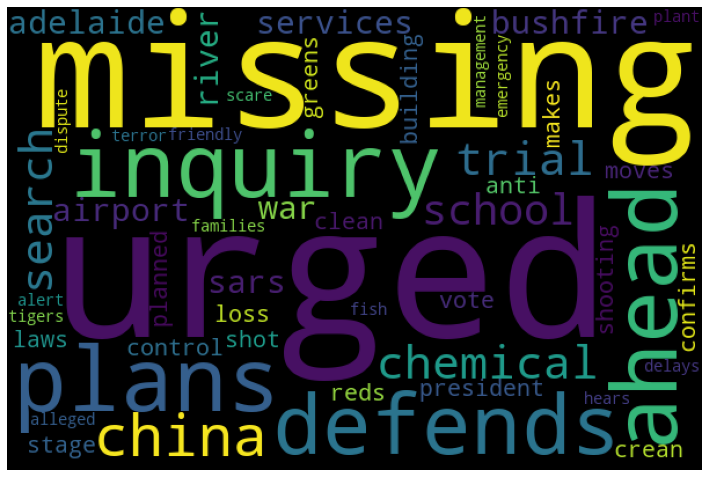

In [136]:
# topic 0
draw_word_cloud(0)

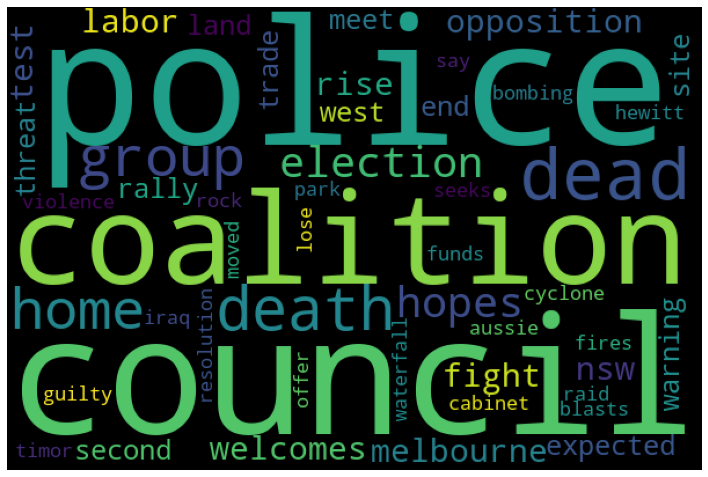

In [137]:
# topic 0
draw_word_cloud(1)

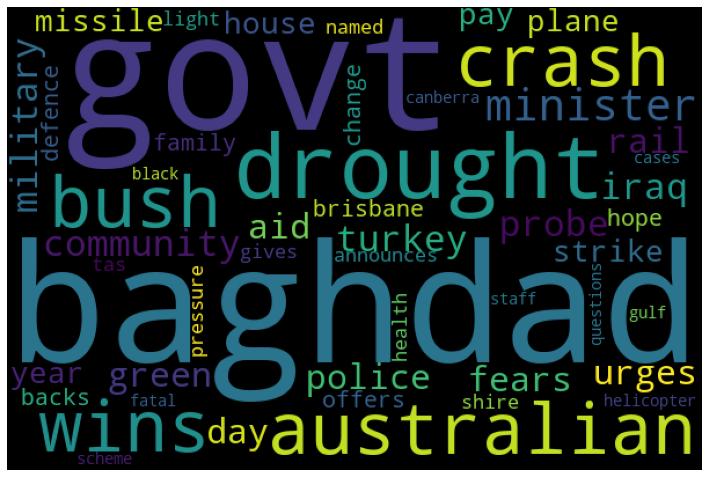

In [139]:
# topic 3
draw_word_cloud(2)

## Gensim Implementation


In [ ]:
import gensim
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from collections import defaultdict
import re
np.random.seed(0)

In [163]:
df_small

,headline_text,headline_cleaned_text
0,aba decides against community broadcasting lic...,"[aba, decides, against, community, broadcastin..."
1,act fire witnesses must be aware of defamation,"[act, fire, witnesses, must, aware, defamation]"
2,a g calls for infrastructure protection summit,"[calls, for, infrastructure, protection, summit]"
3,air nz staff in aust strike for pay rise,"[air, staff, aust, strike, for, pay, rise]"
4,air nz strike to affect australian travellers,"[air, strike, affect, australian, travellers]"
...,...,...
9995,vic govt plan aims to reduce water use,"[vic, govt, plan, aims, reduce, water, use]"
9996,vic govt urged to green light marina plan,"[vic, govt, urged, green, light, marina, plan]"
9997,vic nats leave door open on coalition,"[vic, nats, leave, door, open, coalition]"
9998,waterfall survivors tell of train speeding before,"[waterfall, survivors, tell, train, speeding, ..."


### Cleaning Function

In [164]:
def clean_text_1(headline):
    '''
    Step 1: Lemmatization of words using spacy
    Step 2: Include words whose length >= 3. Also remove punctuations.
    Step 3: Join all lemmatized words.
    '''
    word_tokens = nlp(headline)
    punctuations = "?:!.,;"
    tokens = []
    for token in word_tokens:
        if len(token) >= 3 and token.text not in punctuations:
            tokens.append(token.text)
    
    return tokens

# Testing the function
for i in range(2):
    print('Original text: ', df_small['headline_text'][i])

    print('Cleaned text: ', clean_text_1(df_small['headline_text'][i]))
    print('--------')

Original text:  aba decides against community broadcasting licence
Cleaned text:  ['aba', 'decides', 'against', 'community', 'broadcasting', 'licence']
--------
Original text:  act fire witnesses must be aware of defamation
Cleaned text:  ['act', 'fire', 'witnesses', 'must', 'aware', 'defamation']
--------


In [166]:
df_small.loc[:,'headline_cleaned_text'] = df_small.apply(lambda x: clean_text_1(x['headline_text']), axis = 1)
df_small.head()

C:\Users\raghu\AppData\Local\Temp\ipykernel_4524\1973704798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.loc[:,'headline_cleaned_text'] = df_small.apply(lambda x: clean_text_1(x['headline_text']), axis = 1)


,headline_text,headline_cleaned_text
0,aba decides against community broadcasting lic...,"[aba, decides, against, community, broadcastin..."
1,act fire witnesses must be aware of defamation,"[act, fire, witnesses, must, aware, defamation]"
2,a g calls for infrastructure protection summit,"[calls, for, infrastructure, protection, summit]"
3,air nz staff in aust strike for pay rise,"[air, staff, aust, strike, for, pay, rise]"
4,air nz strike to affect australian travellers,"[air, strike, affect, australian, travellers]"


In [167]:
# Takes time to process 5000+ headlines

df_small.shape[0]

10000

In [168]:
df_small['headline_cleaned_text'][:10]

0    [aba, decides, against, community, broadcastin...
1      [act, fire, witnesses, must, aware, defamation]
2     [calls, for, infrastructure, protection, summit]
3           [air, staff, aust, strike, for, pay, rise]
4        [air, strike, affect, australian, travellers]
5              [ambitious, olsson, wins, triple, jump]
6    [antic, delighted, with, record, breaking, barca]
7    [aussie, qualifier, stosur, wastes, four, memp...
8     [aust, addresses, security, council, over, iraq]
9       [australia, locked, into, war, timetable, opp]
Name: headline_cleaned_text, dtype: object

### Dictionary

In [174]:
dictionary = gensim.corpora.Dictionary(df_small['headline_cleaned_text'])
print(dictionary)

Dictionary(9834 unique tokens: ['aba', 'against', 'broadcasting', 'community', 'decides']...)


In [179]:
# words and their indices in the dictionary
print(dictionary.token2id)

{'aba': 0, 'against': 1, 'broadcasting': 2, 'community': 3, 'decides': 4, 'licence': 5, 'act': 6, 'aware': 7, 'defamation': 8, 'fire': 9, 'must': 10, 'witnesses': 11, 'calls': 12, 'for': 13, 'infrastructure': 14, 'protection': 15, 'summit': 16, 'air': 17, 'aust': 18, 'pay': 19, 'rise': 20, 'staff': 21, 'strike': 22, 'affect': 23, 'australian': 24, 'travellers': 25, 'ambitious': 26, 'jump': 27, 'olsson': 28, 'triple': 29, 'wins': 30, 'antic': 31, 'barca': 32, 'breaking': 33, 'delighted': 34, 'record': 35, 'with': 36, 'aussie': 37, 'four': 38, 'match': 39, 'memphis': 40, 'qualifier': 41, 'stosur': 42, 'wastes': 43, 'addresses': 44, 'council': 45, 'iraq': 46, 'over': 47, 'security': 48, 'australia': 49, 'into': 50, 'locked': 51, 'opp': 52, 'timetable': 53, 'war': 54, 'aid': 55, 'contribute': 56, 'million': 57, 'birthday': 58, 'celebrates': 59, 'robson': 60, 'take': 61, 'ahead': 62, 'bathhouse': 63, 'move': 64, 'plans': 65, 'big': 66, 'championship': 67, 'cycling': 68, 'hopes': 69, 'launce

In [180]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 aba
1 against
2 broadcasting
3 community
4 decides
5 licence
6 act
7 aware
8 defamation
9 fire
10 must


In [172]:
dictionary.filter_extremes(no_below = 15, 
                           no_above = 0.5, 
                           keep_n = 100000)

### Bag of Words(BOW)

In [188]:
bow_corpus = [dictionary.doc2bow(doc) for doc in df_small['headline_cleaned_text']]
for i in range(3):
    print(df_small['headline_cleaned_text'][i])
    print(bow_corpus[i])
    print('------------------------------\n')

['aba', 'decides', 'against', 'community', 'broadcasting', 'licence']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]
------------------------------

['act', 'fire', 'witnesses', 'must', 'aware', 'defamation']
[(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]
------------------------------

['calls', 'for', 'infrastructure', 'protection', 'summit']
[(12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]
------------------------------



In [189]:
len(bow_corpus)

10000

In [165]:
NUM_TOPICS = 10
STOPWORDS = stopwords.words('english')

In [195]:
bow_corpus[9999]

[(75, 1), (1708, 1), (2203, 1), (3215, 1), (7539, 1)]

### TD-IDF Model

In [196]:
tfidf_model = models.TfidfModel(bow_corpus)
index = similarities.SparseMatrixSimilarity(tfidf_model[bow_corpus], num_features = len(dictionary))
bow_doc_9999 = bow_corpus[9999]

for i in range(len(bow_doc_9999)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_9999[i][0], 
                                                     dictionary[bow_doc_9999[i][0]], 
                                                     bow_doc_9999[i][1]))

Word 75 ("water") appears 1 time.
Word 1708 ("studies") appears 1 time.
Word 2203 ("without") appears 1 time.
Word 3215 ("moved") appears 1 time.
Word 7539 ("gallop") appears 1 time.


In [198]:
from pprint import pprint

for doc in tfidf_model[bow_corpus]:
    pprint(doc)
    break

[(0, 0.45536580858284564),
 (1, 0.24208963735300926),
 (2, 0.5170382990818599),
 (3, 0.29310981835213595),
 (4, 0.45536580858284564),
 (5, 0.4164547993501646)]


### LSI Model

In [ ]:
lsi_model = models.lsiModel(bow_corpus)


### LDA Model using Bag of Words

In [208]:
lda_model_bow = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics = 5, 
                                       id2word = dictionary, 
                                       passes = 2, 
                                       workers = 2)

# 
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.026*"for" + 0.009*"over" + 0.009*"with" + 0.006*"sars" + 0.005*"police" + 0.005*"from" + 0.004*"new" + 0.004*"the" + 0.004*"fire" + 0.004*"war"
Topic: 1 
Words: 0.026*"for" + 0.013*"war" + 0.007*"council" + 0.006*"anti" + 0.006*"govt" + 0.006*"police" + 0.005*"after" + 0.004*"may" + 0.004*"hospital" + 0.004*"call"
Topic: 2 
Words: 0.026*"for" + 0.011*"iraq" + 0.008*"after" + 0.006*"govt" + 0.005*"the" + 0.005*"sars" + 0.005*"iraqi" + 0.005*"plan" + 0.005*"death" + 0.005*"police"
Topic: 3 
Words: 0.015*"for" + 0.009*"iraq" + 0.009*"war" + 0.005*"iraqi" + 0.005*"says" + 0.005*"baghdad" + 0.004*"after" + 0.004*"out" + 0.004*"korea" + 0.004*"with"
Topic: 4 
Words: 0.022*"over" + 0.013*"iraq" + 0.009*"man" + 0.006*"baghdad" + 0.006*"out" + 0.006*"more" + 0.006*"court" + 0.005*"war" + 0.005*"new" + 0.005*"face"


### LDA Model using TF-IDF

In [204]:
tfidf_model = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf_model[bow_corpus]

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                             num_topics = 5, 
                                             id2word = dictionary, 
                                             passes = 2, 
                                             workers = 4)

# 
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"for" + 0.004*"war" + 0.003*"over" + 0.003*"police" + 0.003*"new" + 0.003*"iraq" + 0.002*"iraqi" + 0.002*"killed" + 0.002*"anti" + 0.002*"more"
Topic: 1 Word: 0.006*"for" + 0.003*"the" + 0.003*"after" + 0.003*"govt" + 0.002*"iraqi" + 0.002*"iraq" + 0.002*"coalition" + 0.002*"council" + 0.002*"out" + 0.002*"man"
Topic: 2 Word: 0.005*"iraq" + 0.005*"war" + 0.004*"over" + 0.004*"for" + 0.004*"crash" + 0.003*"after" + 0.003*"with" + 0.003*"police" + 0.002*"may" + 0.002*"water"
Topic: 3 Word: 0.005*"for" + 0.004*"war" + 0.004*"iraq" + 0.004*"baghdad" + 0.003*"over" + 0.003*"says" + 0.003*"police" + 0.002*"council" + 0.002*"with" + 0.002*"forces"
Topic: 4 Word: 0.006*"for" + 0.004*"iraq" + 0.003*"war" + 0.003*"over" + 0.003*"nsw" + 0.003*"iraqi" + 0.002*"says" + 0.002*"back" + 0.002*"new" + 0.002*"australian"


### Testing our Topic Model - Classification of the Topics

Performance evaluation by classifying sample document using LDA Bag of Words model.

In [215]:
df_small['headline_text'][9999]

'water wont be moved without studies gallop'

In [211]:
for index, score in sorted(lda_model_bow[bow_corpus[9999]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_bow.print_topic(index, 10)))



Score: 0.8640292882919312	 
Topic: 0.015*"for" + 0.009*"iraq" + 0.009*"war" + 0.005*"iraqi" + 0.005*"says" + 0.005*"baghdad" + 0.004*"after" + 0.004*"out" + 0.004*"korea" + 0.004*"with"

Score: 0.034305356442928314	 
Topic: 0.026*"for" + 0.011*"iraq" + 0.008*"after" + 0.006*"govt" + 0.005*"the" + 0.005*"sars" + 0.005*"iraqi" + 0.005*"plan" + 0.005*"death" + 0.005*"police"

Score: 0.03426552936434746	 
Topic: 0.026*"for" + 0.009*"over" + 0.009*"with" + 0.006*"sars" + 0.005*"police" + 0.005*"from" + 0.004*"new" + 0.004*"the" + 0.004*"fire" + 0.004*"war"

Score: 0.03373893350362778	 
Topic: 0.022*"over" + 0.013*"iraq" + 0.009*"man" + 0.006*"baghdad" + 0.006*"out" + 0.006*"more" + 0.006*"court" + 0.005*"war" + 0.005*"new" + 0.005*"face"

Score: 0.0336608849465847	 
Topic: 0.026*"for" + 0.013*"war" + 0.007*"council" + 0.006*"anti" + 0.006*"govt" + 0.006*"police" + 0.005*"after" + 0.004*"may" + 0.004*"hospital" + 0.004*"call"


`Topmost document` has the highest probability to be part of the topic on the top.

### Performance Evaluation of classifying using LDA TF-IDF model

In [210]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8977232575416565	 
Topic: 0.006*"for" + 0.004*"war" + 0.003*"over" + 0.003*"police" + 0.003*"new" + 0.003*"iraq" + 0.002*"iraqi" + 0.002*"killed" + 0.002*"anti" + 0.002*"more"

Score: 0.025871697813272476	 
Topic: 0.006*"for" + 0.003*"the" + 0.003*"after" + 0.003*"govt" + 0.002*"iraqi" + 0.002*"iraq" + 0.002*"coalition" + 0.002*"council" + 0.002*"out" + 0.002*"man"

Score: 0.025640511885285378	 
Topic: 0.006*"for" + 0.004*"iraq" + 0.003*"war" + 0.003*"over" + 0.003*"nsw" + 0.003*"iraqi" + 0.002*"says" + 0.002*"back" + 0.002*"new" + 0.002*"australian"

Score: 0.02544020302593708	 
Topic: 0.005*"for" + 0.004*"war" + 0.004*"iraq" + 0.004*"baghdad" + 0.003*"over" + 0.003*"says" + 0.003*"police" + 0.002*"council" + 0.002*"with" + 0.002*"forces"

Score: 0.02532433718442917	 
Topic: 0.005*"iraq" + 0.005*"war" + 0.004*"over" + 0.004*"for" + 0.004*"crash" + 0.003*"after" + 0.003*"with" + 0.003*"police" + 0.002*"may" + 0.002*"water"


`Topmost document` has the highest probability to be part of the topic on the top.

## Testing the model on Un-seen Headlines

source: https://timesofindia.indiatimes.com/auto/electric-bikes/electric-scooter-fire-nearly-claims-another-life-rider-jumps-from-moving-scooter-to-save-himself/articleshow/95121033.cms

In [245]:
bow_vector = dictionary.doc2bow(clean_text_1(unseen_document))

def test_model(unseen_document):
    print(unseen_document, '\n')
    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
        print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 10)))

unseen_document = 'Electric scooter fire nearly claims another life: Rider jumps from moving scooter to save himself'
test_model(unseen_document)

Electric scooter fire nearly claims another life: Rider jumps from moving scooter to save himself 

Score: 0.8842268586158752	 Topic: 0.036*"for" + 0.009*"out" + 0.008*"after" + 0.007*"baghdad" + 0.007*"war" + 0.006*"iraqi" + 0.006*"not" + 0.005*"crash" + 0.005*"may" + 0.004*"police"
Score: 0.02900383435189724	 Topic: 0.018*"for" + 0.016*"over" + 0.011*"war" + 0.008*"council" + 0.008*"police" + 0.007*"iraq" + 0.006*"after" + 0.005*"fire" + 0.005*"the" + 0.005*"more"
Score: 0.028945520520210266	 Topic: 0.018*"iraq" + 0.008*"with" + 0.007*"govt" + 0.007*"sars" + 0.006*"says" + 0.006*"war" + 0.004*"over" + 0.004*"for" + 0.004*"after" + 0.004*"more"
Score: 0.028923040255904198	 Topic: 0.011*"for" + 0.011*"man" + 0.009*"with" + 0.009*"over" + 0.006*"claims" + 0.006*"says" + 0.005*"the" + 0.005*"iraqi" + 0.004*"into" + 0.004*"troops"
Score: 0.02890077605843544	 Topic: 0.024*"for" + 0.010*"war" + 0.010*"new" + 0.009*"iraq" + 0.006*"over" + 0.004*"court" + 0.004*"baghdad" + 0.004*"govt" + 0.00

In [241]:
unseen_document = 'Supreme Court notice to Centre on plea against supply of electoral roll to candidates'
test_model(unseen_document)

Supreme Court notice to Centre on plea against supply of electoral roll to candidates 

Score: 0.5408230423927307	 Topic: 0.018*"iraq" + 0.008*"with" + 0.007*"govt" + 0.007*"sars" + 0.006*"says" + 0.006*"war" + 0.004*"over" + 0.004*"for" + 0.004*"after" + 0.004*"more"
Score: 0.2284695953130722	 Topic: 0.018*"for" + 0.016*"over" + 0.011*"war" + 0.008*"council" + 0.008*"police" + 0.007*"iraq" + 0.006*"after" + 0.005*"fire" + 0.005*"the" + 0.005*"more"
Score: 0.18951311707496643	 Topic: 0.011*"for" + 0.011*"man" + 0.009*"with" + 0.009*"over" + 0.006*"claims" + 0.006*"says" + 0.005*"the" + 0.005*"iraqi" + 0.004*"into" + 0.004*"troops"
Score: 0.02062009647488594	 Topic: 0.024*"for" + 0.010*"war" + 0.010*"new" + 0.009*"iraq" + 0.006*"over" + 0.004*"court" + 0.004*"baghdad" + 0.004*"govt" + 0.004*"troops" + 0.004*"police"
Score: 0.020574165508151054	 Topic: 0.036*"for" + 0.009*"out" + 0.008*"after" + 0.007*"baghdad" + 0.007*"war" + 0.006*"iraqi" + 0.006*"not" + 0.005*"crash" + 0.005*"may" + 0

In [242]:
unseen_document = 'Not planning to cut 75% of jobs, Elon Musk tells Twitter employees'
test_model(unseen_document)

Not planning to cut 75% of jobs, Elon Musk tells Twitter employees 

Score: 0.5407264828681946	 Topic: 0.018*"iraq" + 0.008*"with" + 0.007*"govt" + 0.007*"sars" + 0.006*"says" + 0.006*"war" + 0.004*"over" + 0.004*"for" + 0.004*"after" + 0.004*"more"
Score: 0.22847852110862732	 Topic: 0.018*"for" + 0.016*"over" + 0.011*"war" + 0.008*"council" + 0.008*"police" + 0.007*"iraq" + 0.006*"after" + 0.005*"fire" + 0.005*"the" + 0.005*"more"
Score: 0.18960052728652954	 Topic: 0.011*"for" + 0.011*"man" + 0.009*"with" + 0.009*"over" + 0.006*"claims" + 0.006*"says" + 0.005*"the" + 0.005*"iraqi" + 0.004*"into" + 0.004*"troops"
Score: 0.02062016725540161	 Topic: 0.024*"for" + 0.010*"war" + 0.010*"new" + 0.009*"iraq" + 0.006*"over" + 0.004*"court" + 0.004*"baghdad" + 0.004*"govt" + 0.004*"troops" + 0.004*"police"
Score: 0.02057426981627941	 Topic: 0.036*"for" + 0.009*"out" + 0.008*"after" + 0.007*"baghdad" + 0.007*"war" + 0.006*"iraqi" + 0.006*"not" + 0.005*"crash" + 0.005*"may" + 0.004*"police"


In [243]:
unseen_document = df['headline_text'][9000]
test_model(unseen_document)

tigers seeking leave to appeal odonnell suspension 

Score: 0.5399624705314636	 Topic: 0.018*"iraq" + 0.008*"with" + 0.007*"govt" + 0.007*"sars" + 0.006*"says" + 0.006*"war" + 0.004*"over" + 0.004*"for" + 0.004*"after" + 0.004*"more"
Score: 0.22946058213710785	 Topic: 0.018*"for" + 0.016*"over" + 0.011*"war" + 0.008*"council" + 0.008*"police" + 0.007*"iraq" + 0.006*"after" + 0.005*"fire" + 0.005*"the" + 0.005*"more"
Score: 0.18938380479812622	 Topic: 0.011*"for" + 0.011*"man" + 0.009*"with" + 0.009*"over" + 0.006*"claims" + 0.006*"says" + 0.005*"the" + 0.005*"iraqi" + 0.004*"into" + 0.004*"troops"
Score: 0.020618868991732597	 Topic: 0.024*"for" + 0.010*"war" + 0.010*"new" + 0.009*"iraq" + 0.006*"over" + 0.004*"court" + 0.004*"baghdad" + 0.004*"govt" + 0.004*"troops" + 0.004*"police"
Score: 0.02057424932718277	 Topic: 0.036*"for" + 0.009*"out" + 0.008*"after" + 0.007*"baghdad" + 0.007*"war" + 0.006*"iraqi" + 0.006*"not" + 0.005*"crash" + 0.005*"may" + 0.004*"police"
